In [37]:
import pandas as pd
import seaborn as sns
from scipy import stats
from pandas.api.types import is_numeric_dtype
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import pandas as pd
import seaborn as sns
from scipy import stats
from pandas.api.types import is_numeric_dtype
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_regression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('fifa21_raw_data.csv',low_memory=False)
df = data.copy()

In [3]:
df.head()

,photoUrl,LongName,playerUrl,Nationality,Positions,Name,Age,↓OVA,POT,Team & Contract,...,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits
0,https://cdn.sofifa.com/players/158/023/21_60.png,Lionel Messi,http://sofifa.com/player/158023/lionel-messi/2...,Argentina,RW ST CF,L. Messi,33,93,93,\n\n\n\nFC Barcelona\n2004 ~ 2021\n\n,...,Medium,Low,5 ★,85,92,91,95,38,65,\n372
1,https://cdn.sofifa.com/players/020/801/21_60.png,C. Ronaldo dos Santos Aveiro,http://sofifa.com/player/20801/c-ronaldo-dos-s...,Portugal,ST LW,Cristiano Ronaldo,35,92,92,\n\n\n\nJuventus\n2018 ~ 2022\n\n,...,High,Low,5 ★,89,93,81,89,35,77,\n344
2,https://cdn.sofifa.com/players/200/389/21_60.png,Jan Oblak,http://sofifa.com/player/200389/jan-oblak/210005/,Slovenia,GK,J. Oblak,27,91,93,\n\n\n\nAtlético Madrid\n2014 ~ 2023\n\n,...,Medium,Medium,3 ★,87,92,78,90,52,90,\n86
3,https://cdn.sofifa.com/players/192/985/21_60.png,Kevin De Bruyne,http://sofifa.com/player/192985/kevin-de-bruyn...,Belgium,CAM CM,K. De Bruyne,29,91,91,\n\n\n\nManchester City\n2015 ~ 2023\n\n,...,High,High,4 ★,76,86,93,88,64,78,\n163
4,https://cdn.sofifa.com/players/190/871/21_60.png,Neymar da Silva Santos Jr.,http://sofifa.com/player/190871/neymar-da-silv...,Brazil,LW CAM,Neymar Jr,28,91,91,\n\n\n\nParis Saint-Germain\n2017 ~ 2022\n\n,...,High,Medium,5 ★,91,85,86,94,36,59,\n273


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18979 entries, 0 to 18978
Data columns (total 77 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   photoUrl          18979 non-null  object
 1   LongName          18979 non-null  object
 2   playerUrl         18979 non-null  object
 3   Nationality       18979 non-null  object
 4   Positions         18979 non-null  object
 5   Name              18979 non-null  object
 6   Age               18979 non-null  int64 
 7   ↓OVA              18979 non-null  int64 
 8   POT               18979 non-null  int64 
 9   Team & Contract   18979 non-null  object
 10  ID                18979 non-null  int64 
 11  Height            18979 non-null  object
 12  Weight            18979 non-null  object
 13  foot              18979 non-null  object
 14  BOV               18979 non-null  int64 
 15  BP                18979 non-null  object
 16  Growth            18979 non-null  int64 
 17  Joined      

#  Néttoyage des données

Columns to clean

Team & Contract
hits
joined
Height
Weight
Value
Wage
Positons

In [5]:
#some of the 77 columns arent needed so they will be dropped
columns_to_drop = ['photoUrl','playerUrl','Loan Date End', 'Release Clause']
df = df.drop(columns = columns_to_drop)

In [6]:
#splitting team and contract into 2 seperate columns 
df['Team & Contract'] = df['Team & Contract'].astype('str') 
df['Team & Contract'].replace('\n', '', regex=True, inplace=True)
test = df['Team & Contract'][0]

Team = []
Contract_Duration = []
for x in range(len(df['Team & Contract'])):
    Team.append(str(df['Team & Contract'][x][:-11]))
    c = str(df['Team & Contract'][x][-11:])
    if c.startswith("2") == True: # if the format is valid, starts with 2 , like 2023...
        Contract_Duration.append(c)
    else: # the format of the contract is not valid
        Contract_Duration.append("0")
df = df.drop(columns = ['Team & Contract'])   
df['Team'] = Team
df['Contract Duration'] = Contract_Duration

In [7]:
df.head()

,LongName,Nationality,Positions,Name,Age,↓OVA,POT,ID,Height,Weight,...,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits,Team,Contract Duration
0,Lionel Messi,Argentina,RW ST CF,L. Messi,33,93,93,158023,"5'7""",159lbs,...,5 ★,85,92,91,95,38,65,\n372,FC Barcelona,2004 ~ 2021
1,C. Ronaldo dos Santos Aveiro,Portugal,ST LW,Cristiano Ronaldo,35,92,92,20801,"6'2""",183lbs,...,5 ★,89,93,81,89,35,77,\n344,Juventus,2018 ~ 2022
2,Jan Oblak,Slovenia,GK,J. Oblak,27,91,93,200389,"6'2""",192lbs,...,3 ★,87,92,78,90,52,90,\n86,Atlético Madrid,2014 ~ 2023
3,Kevin De Bruyne,Belgium,CAM CM,K. De Bruyne,29,91,91,192985,"5'11""",154lbs,...,4 ★,76,86,93,88,64,78,\n163,Manchester City,2015 ~ 2023
4,Neymar da Silva Santos Jr.,Brazil,LW CAM,Neymar Jr,28,91,91,190871,"5'9""",150lbs,...,5 ★,91,85,86,94,36,59,\n273,Paris Saint-Germain,2017 ~ 2022


In [8]:
#cleaning hits column from object format to int objects / néttoyer la colonne hits du format objet aux objets int
hits = []
for x in range(len(df["Hits"])):
    s = str(df["Hits"][x][1:])
    s = s.replace('K','00')
    s = s.replace('.','')
    hits.append(s)
df['Hits'] = hits
df = df.astype({'Hits':'int'})

In [9]:
#will have to convert Joined to proper date-time format
df['Joined']

0         Jul 1, 2004
1        Jul 10, 2018
2        Jul 16, 2014
3        Aug 30, 2015
4         Aug 3, 2017
             ...     
18974     Aug 1, 2020
18975     Aug 1, 2020
18976    Jul 13, 2018
18977     Aug 1, 2020
18978     Jan 1, 2020
Name: Joined, Length: 18979, dtype: object

In [10]:
#Switching string of months to interger equivelents, wish we could use a case statement
def month_to_number(x):
            if x== 'Jan':
                return 1
            elif x == 'Feb':
                return 2
            elif x == 'Mar': 
                return 3
            elif x == 'Apr':
                return 4
            elif x == 'May':
                return 5
            elif x == 'Jun': 
                return 6
            elif x == 'Jul': 
                return 7
            elif x == 'Aug': 
                return 8
            elif x == 'Sep': 
                return 9
            elif x == 'Oct': 
                return 10
            elif x == 'Nov':  
                return 11
            elif x == 'Dec':  
                return 12

In [11]:
date = []
for x in range(len(df['Joined'])):
    d = df['Joined'][x]
    c = d.split(" ")
    month = str(month_to_number(c[0]))
    day = str(c[1].replace(',',''))
    year = str(c[2])
    if len(day) == 1:
        day = ('0'+str(day))
    date_long = (str(month)+'/'+str(day)+'/'+str(year))
    date_con = pd.to_datetime(date_long)
    date.append(date_con)  

In [12]:
df['Joined'] = date
df['Joined']

0       2004-07-01
1       2018-07-10
2       2014-07-16
3       2015-08-30
4       2017-08-03
           ...    
18974   2020-08-01
18975   2020-08-01
18976   2018-07-13
18977   2020-08-01
18978   2020-01-01
Name: Joined, Length: 18979, dtype: datetime64[ns]

In [13]:
#height to inches 
temp_height = []
for x in range(len(df['Height'])):
    x = df['Height'][x].replace('"', '').split("'")
    inches = int(x[0]) * 12 + int(x[1])
    temp_height.append(inches)
df['Height'] = temp_height
df['Height']

0        67
1        74
2        74
3        71
4        69
         ..
18974    70
18975    67
18976    70
18977    69
18978    69
Name: Height, Length: 18979, dtype: int64

In [14]:
#weight in lbs
temp_weight= []
for x in range(len(df['Weight'])):
    temp_weight.append(int(df['Weight'][x].replace('lbs','')))
    
df['Weight'] = temp_weight
df['Weight']

0        159
1        183
2        192
3        154
4        150
        ... 
18974    154
18975    128
18976    146
18977    143
18978    150
Name: Weight, Length: 18979, dtype: int64

In [15]:
#value
temp_value = []
for x in range(len(df['Value'])):
    value = df['Value'][x]
    value = value.replace('€','')
    value = value.replace('K','000')
    value = value.replace('M','000000')
    value = value.replace('.','F')
    if  'F' in value:
        value = value.replace('F','')
        value = value = int(value) / 10
    temp_value.append(int(value))

df['Value']= temp_value
df['Value']

0        67500000
1        46000000
2        75000000
3        87000000
4        90000000
           ...   
18974       35000
18975       60000
18976       40000
18977       60000
18978       60000
Name: Value, Length: 18979, dtype: int64

In [16]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18979 entries, 0 to 18978
Data columns (total 74 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   LongName           18979 non-null  object        
 1   Nationality        18979 non-null  object        
 2   Positions          18979 non-null  object        
 3   Name               18979 non-null  object        
 4   Age                18979 non-null  int64         
 5   ↓OVA               18979 non-null  int64         
 6   POT                18979 non-null  int64         
 7   ID                 18979 non-null  int64         
 8   Height             18979 non-null  int64         
 9   Weight             18979 non-null  int64         
 10  foot               18979 non-null  object        
 11  BOV                18979 non-null  int64         
 12  BP                 18979 non-null  object        
 13  Growth             18979 non-null  int64         
 14  Joined

In [17]:
#Wage
Temp_Wage = []
for x in range(len(df['Wage'])):
    Wage = df['Wage'][x]
    Wage = Wage.replace('€','')
    Wage = Wage.replace('K','000')
    Wage = Wage.replace('M','000000')
    Wage = Wage.replace('.','F')
    if  'F' in Wage:
        Wage = Wage.replace('F','')
        Wage = Wage = int(Wage) / 10
    Temp_Wage.append(int(Wage))

df['Wage']= Temp_Wage
df['Wage']

0        560000
1        220000
2        125000
3        370000
4        270000
          ...  
18974      1000
18975       500
18976      1000
18977       500
18978       500
Name: Wage, Length: 18979, dtype: int64

In [18]:
#positions
df['Positions'].unique()
#far too many unique groupings of positions will need to order them to reduce size

array(['RW ST CF', 'ST LW', 'GK', 'CAM CM', 'LW CAM', 'ST', 'ST LW RW',
       'RW', 'LW', 'CB', 'CDM', 'CF ST', 'CDM CM', 'CDM RB', 'CF CAM',
       'LW RW', 'LW ST', 'CM', 'RM LM CAM', 'RB', 'RW CAM CM', 'LB', 'CF',
       'LM CF', 'ST CF LW', 'RW LW', 'CM CDM', 'CAM RM RW', 'CAM CF ST',
       'CAM RM CF', 'LM ST', 'CM CDM CAM', 'LM', 'CAM RW', 'CB CDM',
       'RM LM RW', 'RW RM', 'CF LW CAM', 'CAM CM CF', 'LW CF', 'CM RM LM',
       'LB LM', 'CAM CM RM', 'CAM CF', 'LM RM LW', 'LM LB CM', 'CM LM LB',
       'RM CM', 'CAM CM LW', 'CB LB', 'RM RB', 'ST RW', 'LM RW LW',
       'RM RW', 'RB LB', 'RB RM', 'RM', 'CAM RM', 'RB RWB', 'CDM CB CM',
       'LM LW RM', 'CM CAM', 'CAM RM ST', 'LM RM', 'LM LWB', 'ST RM CF',
       'RW RM CF', 'LM RM CF', 'RM CF', 'RB CM', 'LW CAM RW', 'CAM LW CM',
       'CM CAM CDM', 'RW LW CAM', 'CM CAM LM', 'CM RM ST', 'CDM CM RB',
       'ST CAM', 'RM ST', 'LB CB LWB', 'CAM LW ST', 'RWB RM', 'CB CDM LB',
       'CM LM RM', 'LM LW', 'RW LW RM', 'RB CDM CM', '

In [19]:
temp_position = []
for x in range(len(df['Positions'])):
    y = sorted(df['Positions'][x].split(" "))
    yx = ' '.join(y)
    temp_position.append(yx)

df['Positions'] = temp_position
df['Positions'] = df['Positions'].astype(object)
df['Positions'].unique()
#ordered the list of positions leaving them in groups

array(['CF RW ST', 'LW ST', 'GK', 'CAM CM', 'CAM LW', 'ST', 'LW RW ST',
       'RW', 'LW', 'CB', 'CDM', 'CF ST', 'CDM CM', 'CDM RB', 'CAM CF',
       'LW RW', 'CM', 'CAM LM RM', 'RB', 'CAM CM RW', 'LB', 'CF', 'CF LM',
       'CF LW ST', 'CAM RM RW', 'CAM CF ST', 'CAM CF RM', 'LM ST',
       'CAM CDM CM', 'LM', 'CAM RW', 'CB CDM', 'LM RM RW', 'RM RW',
       'CAM CF LW', 'CAM CF CM', 'CF LW', 'CM LM RM', 'LB LM',
       'CAM CM RM', 'LM LW RM', 'CM LB LM', 'CM RM', 'CAM CM LW', 'CB LB',
       'RB RM', 'RW ST', 'LM LW RW', 'LB RB', 'RM', 'CAM RM', 'RB RWB',
       'CB CDM CM', 'CAM RM ST', 'LM RM', 'LM LWB', 'CF RM ST',
       'CF RM RW', 'CF LM RM', 'CF RM', 'CM RB', 'CAM LW RW', 'CAM CM LM',
       'CM RM ST', 'CDM CM RB', 'CAM ST', 'RM ST', 'CB LB LWB',
       'CAM LW ST', 'RM RWB', 'CB CDM LB', 'LM LW', 'LW RM RW', 'CM LM',
       'LB LM RM', 'LW RM ST', 'CAM CM ST', 'LB LWB', 'CB RB', 'RM RW ST',
       'LWB', 'CAM LM', 'CAM', 'RB RM RW', 'CF LM LW', 'CAM LM LW',
       'CB RB RWB'

Both .astype(str) and .astype(object) are used to cast a column in a pandas DataFrame to a string data type. The difference between the two is that .astype(str) specifically casts the column to a string data type, while .astype(object) casts the column to a general Python object data type, which includes string, integer, float, and other types.

The advantage of using .astype(object) over .astype(str) is that it allows the column to hold values of different data types, whereas .astype(str) would force all values in the column to be strings. However, it is important to note that working with a column of mixed data types can sometimes lead to unexpected results, so it's important to understand the data and the potential implications before choosing to cast a column to a general object data type.

In general, it is recommended to use .astype(str) when you specifically want to cast a column to a string data type, and to use .astype(object) when you want to cast a column to a general object data type.

#  Visualize Relationships


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

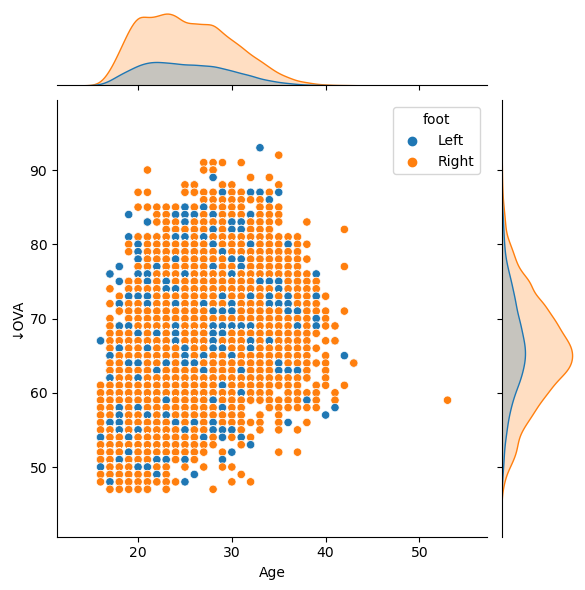

In [21]:
sns.jointplot(data=df, x="Age", y="↓OVA", hue="foot")

There seems to be an outlier for a 53 year old player¶


In [22]:
df.loc[df['Age'] == 53, ['LongName', 'Nationality', 'Team']]
#The oldest Fifa Player plays for a Japanese Team

,LongName,Nationality,Team
16121,Kazuyoshi Miura,Japan,Yokohama FC


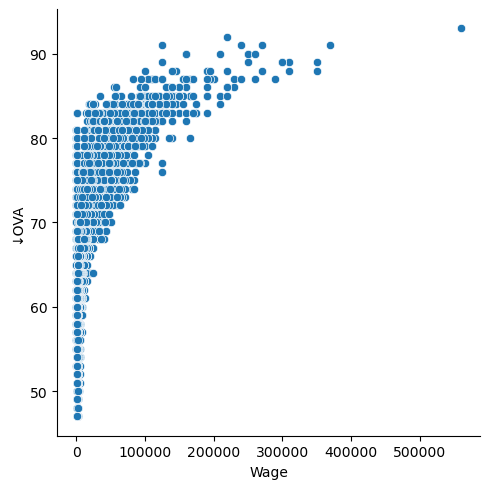

In [23]:
sns.relplot(data=df, x="Wage", y="↓OVA")
#It seems the best performing players are naturally paid the most with one player costing the most by far

In [24]:
#the top 10 most paid players
most_payed = df.nlargest(n=10, columns=['Wage'], keep='all')
most_payed[["Wage",'LongName', 'Nationality', 'Team','↓OVA']]

,Wage,LongName,Nationality,Team,↓OVA
0,560000,Lionel Messi,Argentina,FC Barcelona,93
3,370000,Kevin De Bruyne,Belgium,Manchester City,91
15,350000,Karim Benzema,France,Real Madrid,89
25,350000,Eden Hazard,Belgium,Real Madrid,88
12,310000,Carlos Henrique Venancio Casimiro,Brazil,Real Madrid,89
26,310000,Toni Kroos,Germany,Real Madrid,88
16,300000,Sergio Ramos García,Spain,Real Madrid,89
17,300000,Sergio Agüero,Argentina,Manchester City,89
37,290000,Antoine Griezmann,France,FC Barcelona,87
4,270000,Neymar da Silva Santos Jr.,Brazil,Paris Saint-Germain,91


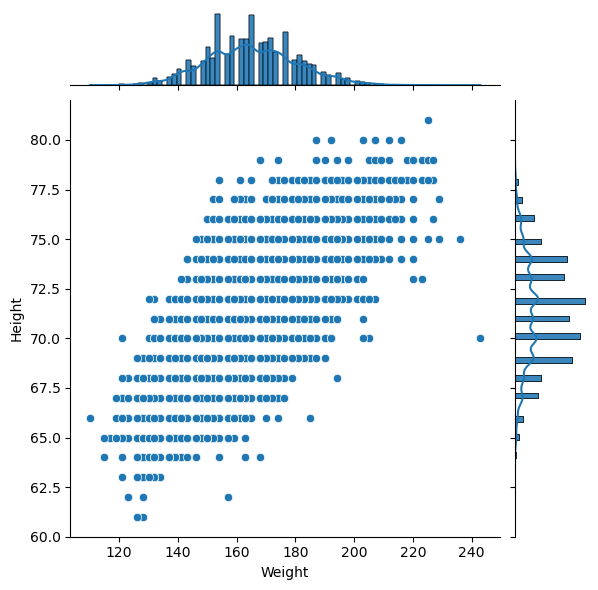

In [25]:
g = sns.JointGrid(data=df, x="Weight", y="Height")
g.plot_marginals(sns.histplot, kde=True)
g.plot(sns.scatterplot, sns.histplot)

In [26]:
heavyiest = df.nlargest(n=5, columns=['Weight'], keep='all')
heavyiest[["Weight",'LongName', 'Nationality', 'Team','↓OVA']]
#the heaviest player is Adebayo Akinfenwa from England

,Weight,LongName,Nationality,Team,↓OVA
10336,243,Adebayo Akinfenwa,England,Wycombe Wanderers,65
9488,236,Chris Seitz,United States,DC United,66
4519,229,Obbi Oularé,Belgium,Standard de Liège,71
4652,229,Fabien Farnolle,Benin,BB Erzurumspor,70
13608,229,Dennis Corozo,Ecuador,Delfín SC,62


In [27]:
Tallest = df.nlargest(n=5, columns=['Height'], keep='all')
Tallest[["Height",'LongName', 'Nationality', 'Team','↓OVA']]
#the tallest player is Tomáš Holý from the Czech Republic

,Height,LongName,Nationality,Team,↓OVA
10305,81,Tomáš Holý,Czech Republic,Ipswich Town,65
4124,80,Costel Pantilimon,Romania,Denizlispor,71
6615,80,Vanja Milinković-Savić,Serbia,Torino,68
8304,80,Kjell Scherpen,Netherlands,Ajax,67
10905,80,Abdoul Ba,Mauritania,AJ Auxerre,64
11216,80,Stefan Maierhofer,Austria,FC Admira Wacker Mödling,64
18191,80,Demba Thiam,Senegal,SPAL,53


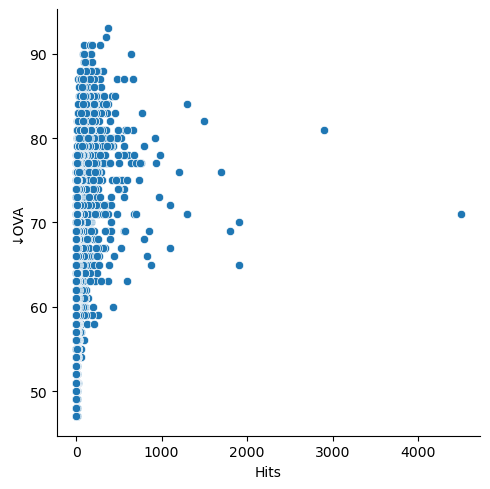

In [28]:
g = sns.relplot(x="Hits", y="↓OVA", data=df)

In [29]:
most_hits = df.nlargest(n=5, columns=['Hits'], keep='all')
most_hits[["Hits",'LongName', 'Nationality', 'Team','↓OVA']]
#the tallest player is Tomáš Holý from the Czech Republic

,Hits,LongName,Nationality,Team,↓OVA
4064,4500,Reinier Jesus Carvalho,Brazil,"Borussia DortmundJun 30, 2",71
279,2900,Marc Cucurella Saseta,Spain,Getafe CF,81
4680,1900,Giovanni Reyna,United States,Borussia Dortmund,70
9707,1900,Enzo Loiodice,France,UD Las Palmas,65
6203,1800,Jude Bellingham,England,Borussia Dortmund,69


In [31]:
df

,LongName,Nationality,Positions,Name,Age,↓OVA,POT,ID,Height,Weight,...,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits,Team,Contract Duration
0,Lionel Messi,Argentina,CF RW ST,L. Messi,33,93,93,158023,67,159,...,5 ★,85,92,91,95,38,65,372,FC Barcelona,2004 ~ 2021
1,C. Ronaldo dos Santos Aveiro,Portugal,LW ST,Cristiano Ronaldo,35,92,92,20801,74,183,...,5 ★,89,93,81,89,35,77,344,Juventus,2018 ~ 2022
2,Jan Oblak,Slovenia,GK,J. Oblak,27,91,93,200389,74,192,...,3 ★,87,92,78,90,52,90,86,Atlético Madrid,2014 ~ 2023
3,Kevin De Bruyne,Belgium,CAM CM,K. De Bruyne,29,91,91,192985,71,154,...,4 ★,76,86,93,88,64,78,163,Manchester City,2015 ~ 2023
4,Neymar da Silva Santos Jr.,Brazil,CAM LW,Neymar Jr,28,91,91,190871,69,150,...,5 ★,91,85,86,94,36,59,273,Paris Saint-Germain,2017 ~ 2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18974,Mengxuan Zhang,China PR,CB,Zhang Mengxuan,21,47,52,257710,70,154,...,1 ★,58,23,26,27,50,48,2,Chongqing Dangdai Lifan FC SWM Team,2020 ~ 2020
18975,Vani Da Silva,England,ST,V. Da Silva,17,47,67,258736,67,128,...,1 ★,70,46,40,53,16,40,3,Oldham Athletic,2020 ~ 2021
18976,Ao Xia,China PR,CB,Xia Ao,21,47,55,247223,70,146,...,1 ★,64,28,26,38,48,51,3,Wuhan Zall,2018 ~ 2022
18977,Ben Hough,England,CM,B. Hough,17,47,67,258760,69,143,...,1 ★,64,40,48,49,35,45,5,Oldham Athletic,2020 ~ 2021


In [32]:
#séparer colonnes numériques et catégorielles
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_cat = df.select_dtypes(include = ['object'])

In [33]:
df_num

,Age,↓OVA,POT,ID,Height,Weight,BOV,Growth,Value,Wage,...,GK Reflexes,Total Stats,Base Stats,PAC,SHO,PAS,DRI,DEF,PHY,Hits
0,33,93,93,158023,67,159,93,0,67500000,560000,...,8,2231,466,85,92,91,95,38,65,372
1,35,92,92,20801,74,183,92,0,46000000,220000,...,11,2221,464,89,93,81,89,35,77,344
2,27,91,93,200389,74,192,91,2,75000000,125000,...,90,1413,489,87,92,78,90,52,90,86
3,29,91,91,192985,71,154,91,0,87000000,370000,...,13,2304,485,76,86,93,88,64,78,163
4,28,91,91,190871,69,150,91,0,90000000,270000,...,11,2175,451,91,85,86,94,36,59,273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18974,21,47,52,257710,70,154,49,5,35000,1000,...,6,1134,232,58,23,26,27,50,48,2
18975,17,47,67,258736,67,128,51,20,60000,500,...,6,1256,265,70,46,40,53,16,40,3
18976,21,47,55,247223,70,146,49,8,40000,1000,...,11,1186,255,64,28,26,38,48,51,3
18977,17,47,67,258760,69,143,51,20,60000,500,...,8,1315,281,64,40,48,49,35,45,5


In [35]:
# prédiction de la colonne 'Wage' en utilisant plusieurs modèles de machine learning
# 'Wage' est la colonne que l'on cherche à prédire
# on va donc la séparer du reste du dataset
y = df_num['Wage']
X = df_num.drop(columns = ['Wage'])



# Régression linéaire

In [38]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) # 70% training and 30% test


reg_all = LinearRegression()

reg_all.fit(X_train, y_train)


y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test))) # R^2 is the coefficient of determination, it is a statistical measure of how close the data are to the fitted regression line
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE is the Root Mean Squared Error, it is the standard deviation of the residuals (prediction errors)
print("Root Mean Squared Error: {}".format(rmse))



R^2: 0.7393398299286815
Root Mean Squared Error: 9303.034134267677


In [ ]:
print

# Decision Tree Regressor

In [44]:
#decision tree regressor
from sklearn.tree import DecisionTreeRegressor

# Create Decision Tree classifer object # créer un objet de type DecisionTreeRegressor
clf = DecisionTreeRegressor()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(clf.score(X_test, y_test))) #
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # 
print("Root Mean Squared Error: {}".format(rmse))




R^2: 0.5417274152099525
Root Mean Squared Error: 12335.285791306738


# Random Forest Regressor

In [40]:
#random forest regressor
from sklearn.ensemble import RandomForestRegressor

# Create Decision Tree classifer object
clf = RandomForestRegressor()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Compute and print R^2 and RMSE

print("R^2: {}".format(clf.score(X_test, y_test))) # R^2 is the coefficient of determination, it is a statistical measure of how close the data are to the fitted regression line
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE is the Root Mean Squared Error, it is the standard deviation of the residuals (prediction errors)
print("Root Mean Squared Error: {}".format(rmse))



R^2: 0.7828939274697664
Root Mean Squared Error: 8490.304432641415


# Gradient Boosting Regressor

In [41]:
#gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor

# Create Decision Tree classifer object
clf = GradientBoostingRegressor()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Compute and print R^2 and RMSE

print("R^2: {}".format(clf.score(X_test, y_test))) # R^2 is the coefficient of determination, it is a statistical measure of how close the data are to the fitted regression line
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE is the Root Mean Squared Error, it is the standard deviation of the residuals (prediction errors)
print("Root Mean Squared Error: {}".format(rmse))



R^2: 0.7671472526141918
Root Mean Squared Error: 8792.815502130265


# Support Vector Regressor

In [42]:
#xgboost regressor
from xgboost import XGBRegressor

# Create Decision Tree classifer object
clf = XGBRegressor()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Compute and print R^2 and RMSE

print("R^2: {}".format(clf.score(X_test, y_test))) # R^2 is the coefficient of determination, it is a statistical measure of how close the data are to the fitted regression line
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE is the Root Mean Squared Error, it is the standard deviation of the residuals (prediction errors)
print("Root Mean Squared Error: {}".format(rmse))



R^2: 0.7806046242510777
Root Mean Squared Error: 8534.950606601169


# XGBoost Regressor

In [45]:
#xgboost regressor
from xgboost import XGBRegressor

# Create Decision Tree classifer object
clf = XGBRegressor()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Compute and print R^2 and RMSE

print("R^2: {}".format(clf.score(X_test, y_test))) # R^2 is the coefficient of determination, it is a statistical measure of how close the data are to the fitted regression line
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE is the Root Mean Squared Error, it is the standard deviation of the residuals (prediction errors)
print("Root Mean Squared Error: {}".format(rmse))



R^2: 0.7806046242510777
Root Mean Squared Error: 8534.950606601169


# LightGBM Regressor

In [46]:
#lightgbm regressor
from lightgbm import LGBMRegressor

# Create Decision Tree classifer object
clf = LGBMRegressor()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Compute and print R^2 and RMSE

print("R^2: {}".format(clf.score(X_test, y_test))) # R^2 is the coefficient of determination, it is a statistical measure of how close the data are to the fitted regression line
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE is the Root Mean Squared Error, it is the standard deviation of the residuals (prediction errors)
print("Root Mean Squared Error: {}".format(rmse))



R^2: 0.7569162887909967
Root Mean Squared Error: 8983.906149338058


In [ ]:
#